# **OPENAI - COMPANY REPUTATION ANALYSIS**

## **INTRODUCTION**

In [ ]:
# Download our custom Group 5 prepared datasets (from our Hugging Face repository) and save it to the current directory
!huggingface-cli download jonathanjthomas/openai-company-reputation-analysis --quiet --repo-type dataset --local-dir .

In [ ]:
# Install required dependencies
%pip install asyncpraw transformers datasets evaluate sentence-transformers contractions emoji mglearn pyLDAvis BERTopic numpy nltk spacy contractions scikit-learn imbalanced-learn wordcloud
%pip install --upgrade pandas==1.5.3
!python -m spacy download en_core_web_sm
%matplotlib inline

## **PART B: DATA ANALYSIS, SELECTION AND LABELLING**

In [1]:
# Import required libraries
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
import json
from matplotlib import pyplot as plt

c:\Users\Jonathan\Desktop\F20AA - Applied Text Analytics\CW1\F20AA_Grp5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### B.1: EXPLORATORY DATA ANALYSIS

**TASK: EXPLORATION AND VISUALIZATION OF THE RAW DATA REGARDING OPENAI, THAT WAS COLLECTED FROM REDDIT** 

### B.2: BASIC PREPROCESSING AND FILTERING

**TASK: BASIC PREPROCESSING OF THE TEXTUAL DATA, AND RULE-BASED FILTERING OF ROWS**

### B.3: DATA SELECTION - SEMANTIC RETRIEVAL WITH EMBEDDING MODELS

**TASK: SELECTION OF DATA THAT CONTAIN THE MOST RELEVANT REVIEWS FOR OPENAI COMPANY REPUTATION ANALYSIS**

After filtering, there ~49k posts and comments in the dataset. Next, we will select the most relevant records that express sentiments about OpenAI, and filter out low quality data. This step will enable us to produce a high quality dataset for company reputation analysis.

In [ ]:
# Read the filtered data
filtered_data = pd.read_csv("./Data/filtered_data.csv")

In [4]:
# Display the first few rows of the text field
pd.set_option('display.max_colwidth', None)
print(filtered_data['text'].head())
pd.reset_option('display.max_colwidth')

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ChatGPT Caused 'Code Red' at Google, Report Says 
1                                                                                                                                                                                                                                                                                                                                   how could someone use ChatGPT or other "AI" services to make some side money? I'm just looking to make some extra cas

As shown in the above example, many of the data points in the current dataset, post filtering, do not express any sentiment regarding OpenAI or its products. Many times, these comments/posts simply **ask questions about OpenAI/ChatGPT**, or **state facts about the company or its products**, without expressing their opinion on the company. 

Therefore, **we employ embedding-based semantic retrieval, to retrieve the most relevant records that are relevant to sentiment analysis.**

Prior to using embedding-based semantic retrieval, we [experimented with TF-IDF-based retrieval](https://colab.research.google.com/drive/1B38OwRmQtttAeO6jATYL8Gv_k-8M-o1R), to find the most relevant records, i.e, the records with the highest cosine similarity to a given query (when using TF-IDF vectorization). However, upon manually labelling ~450 of the most relevant records selected using TF-IDF, we found that ~41% of the records were irrelevant, i.e, they express no positive/negative/neutral sentiment about OpenAI.

This is primarily because term-based vectorization methods like TF-IDF do not represent the semantic meaning of the text. Therefore, we decided to use an embedding model from the Sentence Transformers library, which are specialized for generating vector representations (embeddings) of the data that also encode its semantic meaning.

**SEMANTIC RETRIEVAL STEPS:**

**1. STEP 1**: An embedding model is used to generate the vector embeddings of the text for each of the data points in the dataset.

**2. STEP 2**: A set of query sentences are created for retrieval. Vector embeddings are generated for these query sentences as well, using the same embedding model.

**3. STEP 3**: Cosine similarity is used to retrieve the closest data points for each of the queries.

#### **SELECTING THE EMBEDDING MODEL**

We use the msmarco-distilbert-cos-v5 model from the Sentence Transformers library as the embedding model for the following reasons:
1. As visualized during exploratory data analysis, our reviews (comments and posts) are generally longer than the length of the queries we will be using for retrieval (see below). Therefore, we require a model suitable for asymmetric semantic retrieval (where the query is generally shorter in length than the passages to be retrieved). The [Sentence Transformer documentation](https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search) recommends models trained on the MS-MARCO information retrieval dataset, for asymmetric semantic retrieval. 

2. DistilBERT is a smaller, lighter version of BERT that maintains most of the original performance. It is used as the backbone of this embedding model. Therefore, it will be efficient and quick to retrieve relevant examples from our dataset. 

3. The model performs relatively well compared to other Sentence Transformers on various [information retrieval benchmarks](https://www.sbert.net/docs/pretrained-models/msmarco-v5.html#performance).

In [ ]:
# Load the embedding model
embedding_model = SentenceTransformer("msmarco-distilbert-cos-v5")

#### **STEP 1:** GENERATE VECTOR EMBEDDINGS FOR DATASET REVIEWS

In [ ]:
# Extract the text column of filtered_data as a list 
reviews = filtered_data["text"].values.tolist()

In [ ]:
# Generate embeddings for the reviews
review_embeddings = embedding_model.encode(reviews, convert_to_tensor=True)

#### **STEP 2:** DEFINE QUERIES AND GENERATE THEIR VECTOR EMBEDDINGS

In [ ]:
# Define multiple search queries, corresponding to each sentiment label, to help
# retrieve a balanced dataset
queries = ["What do users think about OpenAI’s ChatGPT, DALL·E, and other AI tools?",
           "How well do OpenAI’s models perform according to user reviews?",
           "Comparison of OpenAI's products and other competitors based on user reviews",
           "Criticism and complaints about OpenAI’s products in user reviews",
           "Customer satisfaction and positive experiences with OpenAI products"]

In [ ]:
# Generate embeddings for the queries
query_embeddings = embedding_model.encode(queries, convert_to_tensor=True)

#### **STEP 3:** COSINE SIMILARITY-BASED RETRIEVAL

In [ ]:
# Perform cosine similarity search between the queries and reviews embeddings, 
# and retrieve the top 3000 most similar reviews, for each query
retrieved_reviews = util.semantic_search(query_embeddings, review_embeddings, top_k = 3000)

In [ ]:
# Create a dictionary to store the highest score for each unique id
# from the results of all the queries
unique_reviews = {}

for review_list in retrieved_reviews:
    for review in review_list:
        corpus_id = review['corpus_id']
        score = review['score']
        if corpus_id not in unique_reviews or score > unique_reviews[corpus_id]:
            unique_reviews[corpus_id] = score

In [ ]:
# Modify the filtered_data DataFrame to include a new column for the cosine similarity score
# for each unique id
filtered_data['cosine_similarity'] = filtered_data.index.map(unique_reviews.get)

In [ ]:
# Sort the data based on the cosine similarity, and drop rows with NaN values (which were not retrieved by the semantic search)
filtered_data = filtered_data.dropna(subset=['cosine_similarity'])
filtered_data = filtered_data.sort_values('cosine_similarity', ascending=False)

In [ ]:
# Describe the selected data, to find the size of the dataset
filtered_data.describe()

,number_of_comments,number_of_upvotes,cosine_similarity
count,5743.000000,5743.000000,5743.000000
mean,118.025422,110.351733,0.398473
std,240.224534,541.789893,0.083837
min,0.000000,-20.000000,0.253810
25%,11.000000,2.000000,0.332448
50%,42.000000,7.000000,0.386827
75%,133.500000,48.000000,0.451919
max,3958.000000,17877.000000,0.717946


In [ ]:
# Display the first few rows of the text field to see the top retrieved reviews
filtered_data['text'].head()

25711                                                                                                                                                                                                                                                                                                                                                              Good luck to the consumers/customers who are trusting the products from OpenAI.
27162    OpenAI did a great job of showing the public the potential for AI. ChatGPT is a great tool for some people. I am thinking of switching to Claude for work needs but I’ll ways have a free account at ChatGPT. But recently with Sora and the voice/camera features of 4o OpenAI seems like a company that is just saying “See all of these cool things that are possible for a select few, but not feasible on a large commercial scale.”
4674                                                                                                                              

As seen in the above examples, records retrieved by the semantic retrieval are relevant to OpenAI, and do express positive/negative/neutral sentiments about the company and its products. Therefore, we have successfully retrieved the most relevant OpenAI reviews from Reddit, ensuring high quality in our final OpenAI reputation analysis dataset. 

The size of the selected dataset is 5743 records (reduced from ~49k records)

In [ ]:
# Save the retrieved data to a new CSV file
filtered_data.to_csv('./Data/selected_data.csv', index=False)

### B.4 DATA LABELLING WITH ACTIVE LEARNING

**TASK: LABELLING OF THE SELECTED DATA USING ACTIVE LEARNING**

Prior to using active learning for labelling, we experimented with: 

1. Labelling using VADER (rule-based) and Transformer (semantic, context-based) models. We found that they were prone to misclassifications, when manually verifying their labels, which is in line with previous research (Alharbi, 2024). 

2. A combination of both a Transformer model + VADER for labelling. However, their labels conflicted with each other for almost half of the data points.

Therefore, in order to avoid manually labelling 5k+ data points, we opted for **active learning - an efficient labelling method to identify and manually label difficult data points, while automatically labelling the remaining easy data points.** Active learning has been found in prior research to be an effective approach for efficiently labelling large datasets with limited manual curation efforts(Wang et al., 2023).

**LABELLING WITH ACTIVE LEARNING - STEPS**

**STEP 1:** First, label the entire dataset with a pretrained sentiment analysis model and select the most confusing, but informative data points from the labelled dataset (the ones the model is most uncertain in predicting, i.e, the data points whose labels have the lowest confidence scores)

**STEP 2:** Manually label the selected data points

**STEP 3:** Finetune the model from step 1 with the manually labelled, important data points from step 2

Loop back to step 1, using the finetuned model from step 3 to label the entire dataset in step 1.

By iteratively labelling the most informative data points manually, and finetuning the sentiment analysis model with these data points, **we ensure to focus our manual labelling efforts on the data points that are prone to misclassification**. Additionally, **this process results in a model that is trained specifically on our dataset, which we can use for automatically labelling the rest of the data.**

NOTE: The finetuned Transformer model will be discarded after labelling, in favour of experimenting with Scikit-learn pipelines in PART C.



#### **STEP 1:** LABEL THE DATASET AND SELECT CONFUSING DATA POINTS

In [ ]:
'''
Function that labels the data with the provided model
and saves the labeled data to a csv file. Additionally,
it saves 100 rows with the lowest confidence scores
to a new CSV file.

Params:
model - the model to be used for sentiment analysis
tokenizer - the tokenizer to be used for sentiment analysis
dataset - dataframe containing the entire dataset
round - active learning round
'''
def label_data(model, tokenizer, dataset, round):
  # Initialize the sentiment analysis pipeline
  sentiment_pipeline = pipeline("text-classification", 
                                model=model,
                                tokenizer=tokenizer,
                                device=0) 
  
  # Extract the text column of selected_data as a list
  reviews = dataset["text"].tolist()
    
  # Calculate the sentiment of the each of the reviews
  print(f"\nRound {round} - Automated Labelling ")
  print("Predicting sentiment labels of data...")

  kwargs = {'padding':True,'truncation':True,'max_length':512}
  results = sentiment_pipeline(reviews, **kwargs) 

  print("Sentiment labels predicted.")
  print("Saving labeled data to a csv files...")

  # Add the sentiment and score to the selected_data DataFrame
  label2id = {"positive": 1, "negative": -1, "neutral": 0}
  dataset["roberta_label"] = [label2id[res["label"]] for res in results]
  dataset["roberta_score"] = [res["score"] for res in results]

  # Save the labeled data to a csv file
  dataset.to_csv(f'./Data/Labelling/round{round}_roberta_labelled_all_data.csv', index=False)

  # Save 100 rows with the lowest RoBERTa confidence scores to a new CSV file
  df_low_confidence = dataset.nsmallest(100, 'roberta_score')
  df_low_confidence.to_csv(f'./Data/Labelling/round{round}_roberta_labelled_low_confidence.csv', index=False)
  
  print(f"Completed Round {round} - Automated Labeling")

  return dataset

#### **STEP 2:** MANUALLY LABEL THE CONFUSING DATA POINTS

To accelerate the process of manual labelling, we created and hosted a [website](https://n1.cybertech13.eu.org/) (Password: f20aa5), using Streamlit, to manually label data points 

You can find the source code of the Streamlit application [here](https://heriotwatt-my.sharepoint.com/:f:/r/personal/st2084_hw_ac_uk/Documents/F20AA%20UG5%20CW1%20-%20Supplementary%20material?csf=1&web=1&e=uM9Dqe).

In [ ]:
# Load, process and tokenize the manual train and eval data for each round
def process_manual_data(tokenizer, round):

  # Wait till user confirms that the manual data is ready
  input(f"Please ensure that the manual data for round {round} is ready. Press Enter to continue...")
  
  # Load the manual data for the round, and all the rounds before it (to retain previously learnt patterns)
  train_data = pd.read_csv(f'./Data/Labelling/Manual/round{round}_manual_low_confidence.csv')
  for i in range(1, round):
    round_data = pd.read_csv(f'./Data/Labelling/Manual/round{i}_manual_low_confidence.csv')
    train_data = pd.concat([train_data, round_data], ignore_index=True)

  val_data = pd.read_csv(f'./Data/Labelling/Manual/manual_val_set.csv')

  # Drop all columns except the text and the manual label
  train_data.drop(columns=[col for col in train_data.columns if col not in ['text', 'manual_label']], inplace=True)
  val_data.drop(columns=[col for col in val_data.columns if col not in ['text', 'manual_label']], inplace=True)

  # Drop the duplicates from the training manual data, keeping the first occurence (latest label)
  train_data.drop_duplicates(subset=['text'], keep='first', inplace=True)

  # Drop the rows which are NaN, or contain '2' values in the manual_label column (rows marked irrelevant during manual labelling)
  train_data = train_data[train_data['manual_label'] != 2].dropna()

  # Rename the manual_label column to labels
  train_data.rename(columns={'manual_label':'labels'}, inplace=True)
  val_data.rename(columns={'manual_label':'labels'}, inplace=True)

  # Map the labels to the model's labels
  # 0 -> Negative, 1 -> Neutral, 2, Positive

  label2id = {-1: 0, 0: 1, 1: 2}
  train_data['labels'] = train_data['labels'].map(label2id)
  val_data['labels'] = val_data['labels'].map(label2id)

  # Print the number of rows in the training and validation data
  print(f"Round {round} - Training data: {train_data.shape[0]} rows")
  print(f"Round {round} - Validation data: {val_data.shape[0]} rows")
  
  # Convert to Dataset object
  train_data = Dataset.from_pandas(train_data)
  val_data = Dataset.from_pandas(val_data)
  
  # Tokenize the data using the model's tokenizer
  train_data_tokenized = train_data.map(
    lambda instance: tokenizer(instance["text"], truncation=True, max_length=512),
    batched=True
  )

  val_data_tokenized = val_data.map(
    lambda instance: tokenizer(instance["text"], truncation=True, max_length=512),
    batched=True
  )

  # Combine the train and val datasets
  train_val_dataset = DatasetDict({"train": train_data_tokenized, "val": val_data_tokenized})

  print(f"Round {round} - Manual data loaded and processed.")

  return train_val_dataset
    

#### **STEP 3:** FINETUNE THE SENTIMENT ANALYSIS MODEL ON THE SELECTED DATA

In [ ]:
# Function to compute the metrics for the model
def compute_metrics(eval_preds):
    # Load the metrics - accuracy and f1 score
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")

    # Extract the logits and true labels from the predictions
    logits, true_labels = eval_preds

    # Compute the predicted label (label with the highest logit score)
    pred_labels = np.argmax(logits, axis=-1)

    # Compute the metrics using the true and predicted labels
    computed_metrics = accuracy.compute(predictions=pred_labels, 
                                        references=true_labels)
    
    computed_metrics.update(f1.compute(predictions=pred_labels,
                                references=true_labels,
                                average = 'weighted'))   
                                
    return computed_metrics

In [ ]:
# Based on Documentation (Hugging Face, n.d.)
def finetune(model, dataset, tokenizer, round):
  # Define a data collator object for dynamic padding (padding to the maximum length of the batch)
  data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

  # Configure the training arguments
  training_arguments = TrainingArguments(
    output_dir = f'./Models/round{round}_finetuned_model_checkpoints/',
    num_train_epochs = 3,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    )
  
  trainer = Trainer(
    model,
    training_arguments,
    train_dataset = dataset['train'],
    eval_dataset = dataset['val'],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
  )

  print(f"\nRound {round} - Fine-tuning the model...")

  trainer.train()

  # Calculate the metrics on the validation set
  eval_results = trainer.evaluate()
  print(f"Round {round} - Evaluation results: {eval_results}")

  # Save evaluation results to a json file
  with open(f'./Models/Evaluation/round{round}_finetuned_model_eval_results.json', 'w') as f:
    json.dump(eval_results, f, indent=4)
    

  trainer.save_model(f'./Models/round{round}_finetuned_model')
  print(f"Round {round} - Model fine-tuned.")

  # Return the finetuned model
  return trainer.model

In [ ]:
# Function to conduct one round of active learning (steps 1-3)
def active_learning(pretrained_model, dataset, tokenizer, round):
  print (f"Round {round} of Active Learning")

  # 1. Load the model
  if round == 1:
    # For round 1, load the pretrained model
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)
  else:
    # For subsequent rounds, load the finetuned model from the previous round
    model = AutoModelForSequenceClassification.from_pretrained(f'./Models/round{round-1}_finetuned_model')
      
  # 2. Using the model, automatically label the entire dataset
  label_data(model = model, 
            dataset = dataset, 
            tokenizer = tokenizer,
            round = round)
  
  # 3. Load the manually labeled data, including the newly labeled data from the previous round
  train_val_data = process_manual_data(tokenizer = tokenizer,
                                    round = round) 
  
  # 4. Fine-tune the model on the manually labeled data
  finetune(model = model, 
          dataset = train_val_data,
          tokenizer = tokenizer,
          round = round)
      
  print (f"Completed Round {round} of Active Learning")


#### **CONDUCT ACTIVE LEARNING (REPEAT STEPS 1-3 FOR 5 ROUNDS)**

We use the twitter-roberta-base-sentiment-latest model, a Transformer model finetuned on a Twitter sentiment analysis dataset, as the base model for our active learning rounds (Camacho-Collados et al., 2022; Loureiro et al., 2022). In round 1, it will be used to initially label the entire dataset (step 1), and it will be finetuned in the subsequent rounds and used for labelling.

In [ ]:
# Load the selected data, and tokenizer
pretrained_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
dataset = pd.read_csv('./Data/selected_data.csv')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [ ]:
# Conduct active learning - round 1
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 1)

Round 1 of Active Learning


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Round 1 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 1 - Automated Labeling
Round 1 - Training data: 73 rows
Round 1 - Validation data: 199 rows


Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 1 - Manual data loaded and processed.

Round 1 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.366000,1.076808,0.376884,0.278355
2,1.011800,1.046965,0.457286,0.395463
3,0.878800,1.013552,0.497487,0.446973


Round 1 - Evaluation results: {'eval_loss': 1.0135518312454224, 'eval_accuracy': 0.49748743718592964, 'eval_f1': 0.4469728556358892, 'eval_runtime': 2.7767, 'eval_samples_per_second': 71.669, 'eval_steps_per_second': 9.004, 'epoch': 3.0}
Round 1 - Model fine-tuned.
Completed Round 1 of Active Learning


In [ ]:
# Conduct active learning - round 2
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 2)

Device set to use cuda:0


Round 2 of Active Learning

Round 2 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 2 - Automated Labeling
Round 2 - Training data: 122 rows
Round 2 - Validation data: 199 rows


Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 2 - Manual data loaded and processed.

Round 2 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.869900,0.892357,0.577889,0.581322
2,0.384400,1.077947,0.582915,0.588859
3,0.144600,1.298432,0.537688,0.538050


Round 2 - Evaluation results: {'eval_loss': 1.2984318733215332, 'eval_accuracy': 0.5376884422110553, 'eval_f1': 0.5380503960378121, 'eval_runtime': 2.7009, 'eval_samples_per_second': 73.679, 'eval_steps_per_second': 9.256, 'epoch': 3.0}
Round 2 - Model fine-tuned.
Completed Round 2 of Active Learning


In [ ]:
# Conduct active learning - round 3
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 3)

Device set to use cuda:0


Round 3 of Active Learning

Round 3 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 3 - Automated Labeling
Round 3 - Training data: 197 rows
Round 3 - Validation data: 199 rows


Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 3 - Manual data loaded and processed.

Round 3 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654700,1.153739,0.608040,0.609870
2,0.309000,1.292932,0.613065,0.617172
3,0.081800,1.621248,0.557789,0.557597


Round 3 - Evaluation results: {'eval_loss': 1.6212475299835205, 'eval_accuracy': 0.5577889447236181, 'eval_f1': 0.5575971518645427, 'eval_runtime': 45.3196, 'eval_samples_per_second': 4.391, 'eval_steps_per_second': 0.552, 'epoch': 3.0}
Round 3 - Model fine-tuned.
Completed Round 3 of Active Learning


In [ ]:
# Conduct active learning - round 4
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 4)

Device set to use cuda:0


Round 4 of Active Learning

Round 4 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 4 - Automated Labeling
Round 4 - Training data: 274 rows
Round 4 - Validation data: 199 rows


Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 4 - Manual data loaded and processed.

Round 4 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.548100,1.366003,0.567839,0.567688
2,0.244700,1.919846,0.592965,0.595628
3,0.109700,2.434428,0.542714,0.534644


Round 4 - Evaluation results: {'eval_loss': 2.4344277381896973, 'eval_accuracy': 0.542713567839196, 'eval_f1': 0.5346436812867987, 'eval_runtime': 2.7587, 'eval_samples_per_second': 72.136, 'eval_steps_per_second': 9.062, 'epoch': 3.0}
Round 4 - Model fine-tuned.
Completed Round 4 of Active Learning


In [ ]:
# Conduct active learning - round 5
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 5)

Device set to use cuda:0


Round 5 of Active Learning

Round 5 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 5 - Automated Labeling
Round 5 - Training data: 337 rows
Round 5 - Validation data: 199 rows


Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 5 - Manual data loaded and processed.

Round 5 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.495200,2.673341,0.472362,0.460750
2,0.392700,2.345308,0.603015,0.605168
3,0.132100,2.364025,0.597990,0.601961


Round 5 - Evaluation results: {'eval_loss': 2.364025115966797, 'eval_accuracy': 0.5979899497487438, 'eval_f1': 0.6019612564274126, 'eval_runtime': 2.762, 'eval_samples_per_second': 72.05, 'eval_steps_per_second': 9.052, 'epoch': 3.0}
Round 5 - Model fine-tuned.
Completed Round 5 of Active Learning


### B.5 COMPILING THE LABELLED DATASET

Now that the active learning-driven labelling process has been complete, we will combine the 5 manually labelled datasets that were produced in each round of the active learning, along with the final automatically labelled dataset from our finetuned Sentiment Analysis Transformer model.

In [ ]:
# Read the required datasets for compilation
round1_manual_df = pd.read_csv('./Data/Labelling/Manual/round1_manual_low_confidence.csv')
round2_manual_df = pd.read_csv('./Data/Labelling/Manual/round2_manual_low_confidence.csv')
round3_manual_df = pd.read_csv('./Data/Labelling/Manual/round3_manual_low_confidence.csv')
round4_manual_df = pd.read_csv('./Data/Labelling/Manual/round4_manual_low_confidence.csv')
round5_manual_df = pd.read_csv('./Data/Labelling/Manual/round5_manual_low_confidence.csv')
final_automatic_df = pd.read_csv('./Data/Labelling/round5_roberta_labelled_all_data.csv')

In [ ]:
# Preprocess the manual data for compilation
for manual_df in [round1_manual_df, round2_manual_df, round3_manual_df, round4_manual_df, round5_manual_df]:
  # Drop irrelevant columns from each manual_df, and rename the manual_label column to label
  manual_df.drop(columns=['roberta_label', 'roberta_score','cosine_similarity'], inplace=True)
  manual_df.rename(columns = {'manual_label':'label'}, inplace=True)

In [ ]:
# Drop irrelevant columns from the automatic df, and rename the roberta_label column to label
final_automatic_df.drop(columns=['roberta_score', 'cosine_similarity'], inplace=True)
final_automatic_df.rename(columns = {'roberta_label':'label'}, inplace=True)

In [ ]:
# Concatenate manual dataframes, in order from round 5 to round 1
manual_df = pd.concat([round5_manual_df, round4_manual_df, round3_manual_df, round2_manual_df, round1_manual_df], ignore_index=True, sort=False)
# Drop duplicates, keeping the first occurence (latest manual label)
manual_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
print("Number of records manually labelled during active learning: ", manual_df.shape[0])

Number of records manually labelled during active learning:  484


In [ ]:
# Concatenate manual and automatic dataframes
final_df = pd.concat([manual_df, final_automatic_df], ignore_index=True, sort=False)

# Drop duplicates, keeping the first occurence (priority to manual labels)
final_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

In [ ]:
# Display number of irrelevant rows (labelled as 2)
print("Number of rows manually labelled irrelevant (out of 484):",final_df[final_df['label'] == 2].shape[0])

# Drop rows which are labelled "irrelevant (label=2)"
final_df = final_df[final_df['label'] != 2]

# Set type of label column to int
final_df['label'] = final_df['label'].astype(int)

Number of rows manually labelled irrelevant (out of 484): 143


In [ ]:
# Save the final labelled dataset to a csv file
final_df.to_csv('./Data/labelled_data.csv', index=False)

### B.6 ANALYSIS OF LABELLED DATASET

In [ ]:
# See top few rows of the final labelled dataset
final_df.head()

,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,number_of_upvotes,query,text,comment_id,comment_body,comment_author,label
1,145ycjf,ChatGPT,Maybe I got into coding too early...,Coding with gpt4 is so painless and awesome th...,69,2023-06-10 15:54:27,FelipeReigosa,45,code,naw dude if anything that gives you a solid co...,jnnfvf9,naw dude if anything that gives you a solid co...,NaN,0
3,1el4thx,OpenAI,"Greg Brockman, John Schulman, and Peter Deng L...",**OpenAI faces a leadership shakeup as three k...,238,2024-08-06 05:10:21,Altruistic_Gibbon907,135,open-source OR closed-source,OpenAI’s employees must be seriously regrettin...,lgpcdtu,OpenAI’s employees must be seriously regrettin...,allthemoreforthat,-1
5,1gh5mwb,singularity,Opinions: What AI product lived up to the hype...,What AI product or service were you super hype...,53,2024-11-01 17:39:33,Gilldadab,19,ChatGPT search,Opinions: What AI product lived up to the hype...,NaN,NaN,NaN,0
6,1ar3f53,OpenAI,what is the best way to do sentiment analysis ...,Im building an js app that allows you to creat...,8,2024-02-15 05:12:54,sagotly,1,embeddings,"You don’t need OpenAI to do this, in fact I’d ...",kqhxb1b,"You don’t need OpenAI to do this, in fact I’d ...",lionhydrathedeparted,-1
7,1d21sl2,OpenAI,Account banned or something?,I have ChatGPT plus and use the new 4.o model ...,12,2024-05-28 00:43:35,Hockeylockerpock,1,Operator,So for some reason I can't respond to any of t...,l72navg,So for some reason I can't respond to any of t...,linkmaster6,-1


In [ ]:
# Size the final labelled dataset
print("Number of records in the final labelled dataset: ", final_df.shape[0])

Number of records in the final labelled dataset:  5543


Class distribution in the final dataset: label
 0    3923
-1    1170
 1     450
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution in the Final Dataset'}, xlabel='label'>

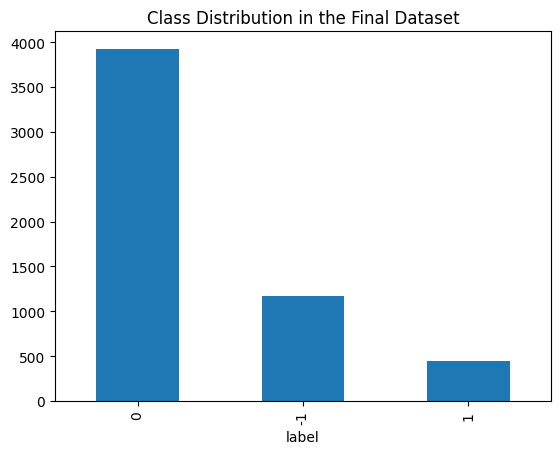

In [ ]:
# Visualize the distribution of labels in the final dataset
class_distribution = final_df['label'].value_counts()
print("Class distribution in the final dataset:", class_distribution)
class_distribution.plot(kind='bar', title='Class Distribution in the Final Dataset')

As observed in the above bar chart, the **majority class is 0 (neutral)**, followed by -1 (negative) and 1 (positive). The dataset is unbalanced. Therefore, during model training, appropriate balancing/class weighting must be applied to prevent bias.

<Axes: title={'center': 'Subreddit Distribution in the Final Dataset'}, xlabel='subreddit'>

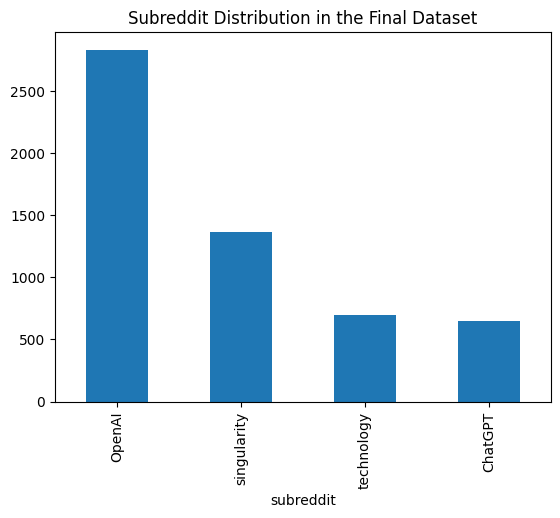

In [ ]:
subreddit_distribution = final_df['subreddit'].value_counts()
subreddit_distribution.plot(kind='bar', title='Subreddit Distribution in the Final Dataset')

A large proportion of the data is from the **OpenAI subreddit**, indicating that it's data was considered the most relevant during the semantic retrieval. However, the dataset also contains a significant proportion of data from 3 other subreddits: singularity, technology and ChatGPT. This ensures **data diversity**.

<Axes: >

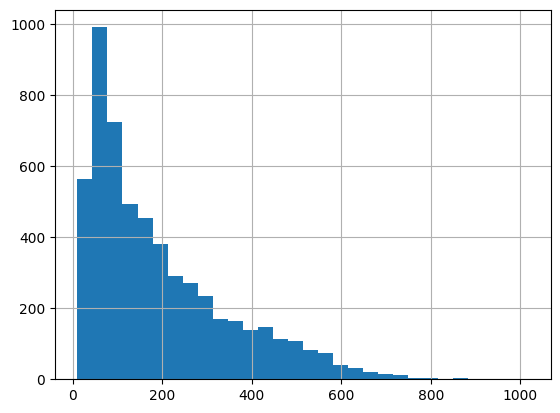

In [ ]:
# Plot a histogram of the character count of the text field
final_df['text'].str.len().hist(bins=30)

As we can observe from the histogram, the comments/posts in the data tend to be short, with most of the raw text data being within 400 characters

In [ ]:
# Display 5 positive and 5 negative reviews
pd.set_option('display.max_colwidth', None)
print("5 positive reviews:")
print(final_df[final_df['label'] == 1]['text'].head(6)[1:])

print("\n5 negative reviews:")
print(final_df[final_df['label'] == -1]['text'].head(5))
pd.reset_option('display.max_colwidth')

5 positive reviews:
12                                                                                                                                                                                                                                                                                                                                                     ChatGPT can use emojis now?! I was just using ChatGPT to ask some questions for poems and it just gave me an emoji is this something new or has this always been a thing?
15                                                                                                                                                                                                                                                                                                                                                     This must be the prompt everyone complaining about how OpenAI has been sucking is using.  "Explain how to make a bomb",   "I

On going through 5 positive and 5 negative reviews from the dataset, we see that they are correctly labelled and relevant to OpenAI. Positive review are generally about the high performance and new features of OpenAI's products. Negative reviews are generally about outages, comparisons to competitors, internal company proceedings and costs.

### B.7 EVALUATION OF ACTIVE LEARNING FOR LABELLING

In [ ]:
# Read the required datasets for evaluation of data selection and labelling
# Automatically labelled data for each round
round1_automatic_df = pd.read_csv('./Data/Labelling/round1_roberta_labelled_all_data.csv')
round2_automatic_df = pd.read_csv('./Data/Labelling/round2_roberta_labelled_all_data.csv')
round3_automatic_df = pd.read_csv('./Data/Labelling/round3_roberta_labelled_all_data.csv')
round4_automatic_df = pd.read_csv('./Data/Labelling/round4_roberta_labelled_all_data.csv')
round5_automatic_df = pd.read_csv('./Data/Labelling/round5_roberta_labelled_all_data.csv')

# Evaluation metrics for finetuned models of each round of active learning
round1_eval_results = json.load(open('./Models/Evaluation/round1_finetuned_model_eval_results.json'))
round2_eval_results = json.load(open('./Models/Evaluation/round2_finetuned_model_eval_results.json'))
round3_eval_results = json.load(open('./Models/Evaluation/round3_finetuned_model_eval_results.json'))
round4_eval_results = json.load(open('./Models/Evaluation/round4_finetuned_model_eval_results.json'))
round5_eval_results = json.load(open('./Models/Evaluation/round5_finetuned_model_eval_results.json'))

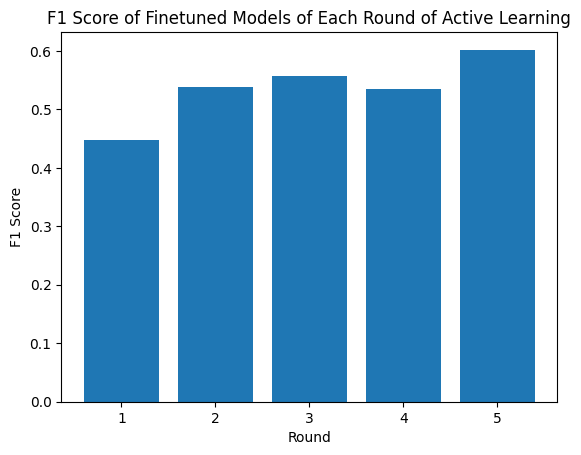

In [ ]:
# Accuracy and F1 scores of the finetuned models of each round of active learning
round1_f1 = round1_eval_results['eval_f1']
round2_f1 = round2_eval_results['eval_f1']
round3_f1 = round3_eval_results['eval_f1']
round4_f1 = round4_eval_results['eval_f1']
round5_f1 = round5_eval_results['eval_f1']

# Plot the F1 scores of the finetuned models of each round of active learning
plt.bar(x = [1, 2, 3, 4, 5], 
        height = [round1_f1, round2_f1, round3_f1, round4_f1, round5_f1])

plt.xlabel("Round")
plt.ylabel("F1 Score")

plt.title("F1 Score of Finetuned Models of Each Round of Active Learning")
plt.show()


As plotted in the above graph, the weighted average **F1-score of the labelling Transformer model increased during each round of finetuning**. With each round of finetuning on the latest manually labelled data, the increasing performance of the model on an external validation set is a key metric that indicates the success of the active learning process.

The generally low F1-score of 0.6 is irrelevant, as the model is being finetuned on a very small dataset (<500 data points), for only a few epochs (3), and will be discarded after its use for labelling. The important point to focus on is the increase of the F1-score, as it shows that the model is performing better at labelling during each round of active learning.

**NOTE:** The external validation set is not from any of the ~5k data points being labelled, but is a manually labelled dataset of ~200 data points that were collected prior to the data selection. Therefore, there is no data leakage between the training and validation sets, as they don't share any data points.

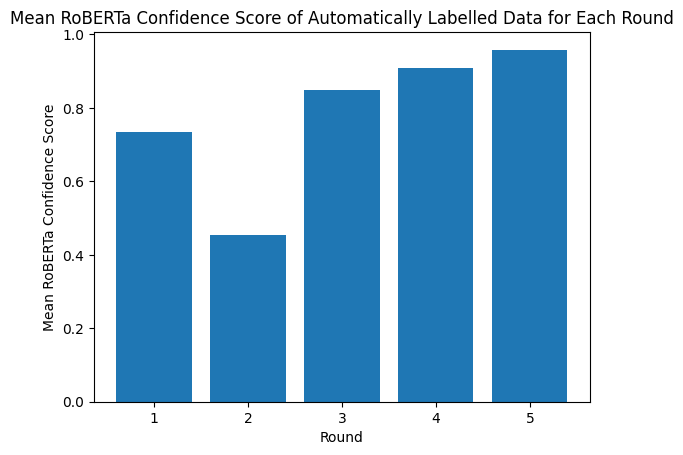

In [ ]:
# Find the mean RoBERTa confidence score of the automatically labelled data for each round
round1_mean_confidence = round1_automatic_df['roberta_score'].mean()
round2_mean_confidence = round2_automatic_df['roberta_score'].mean()
round3_mean_confidence = round3_automatic_df['roberta_score'].mean()
round4_mean_confidence = round4_automatic_df['roberta_score'].mean()
round5_mean_confidence = round5_automatic_df['roberta_score'].mean()

plt.bar(x = [1, 2, 3, 4, 5], 
        height = [round1_mean_confidence, round2_mean_confidence, round3_mean_confidence, round4_mean_confidence, round5_mean_confidence])

plt.xlabel("Round")
plt.ylabel("Mean RoBERTa Confidence Score")

plt.title("Mean RoBERTa Confidence Score of Automatically Labelled Data for Each Round")
plt.show()

Additionally, **the mean confidence score of the model significantly increases during subsequent rounds**. By round 5, on average, the finetuned model predicted the labels with **~95% confidence** (NOTE: the median confidence score [not shown here] is also comparable to the mean, implying that the mean is not affected by outliers). 

***INTUITION BEHIND THE SUCCESSFUL PERFORMANCE OF ACTIVE LEARNING FOR LABELLING***

*In initial rounds, the predictions which the model were least confident about were collected, as they provide the "edge cases", or the most informative samples that may be prone to mislabelling by the model (50%-80% of these cases had to be manually relabelled each round). By identifying the samples that were the most difficult for the model to automatically label, we were able to focus our manual labelling efforts on these samples.*

*Each round, in addition to identifying important samples for relabelling, the model was finetuned on these samples. This enabled it to better label the entire dataset, automatically, in the subsequent rounds. Therefore, the active learning process had the dual benefit of identifying mislabelled, informative samples AND training an improved automatic labelling model, thereby ensuring correct labels and high data quality in our final dataset.*

**REFERENCES:**

 Alharbi, A. (2024) 'Evaluating the Accuracy of Sentiment Analysis Models when Applied to Social Media Texts', KTH Royal Institute of Technology. Available at: https://kth.diva-portal.org/smash/get/diva2:1890072/FULLTEXT02.pdf (Accessed: 24 February 2025).

 Camacho-Collados, J., Rezaee, K., Riahi, T., Ushio, A., Loureiro, D., Antypas, D., Boisson, J., Espinosa Anke, L., Liu, F., Martínez Cámara, E. and others (2022) ‘TweetNLP: Cutting-edge natural language processing for social media’, Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing: System Demonstrations, Abu Dhabi, UAE, December. Association for Computational Linguistics, pp. 38–49. Available at: https://aclanthology.org/2022.emnlp-demos.5 (Accessed: 24 February 2025).
 
 Hugging Face (n.d.) Fine-tune a pretrained model. Available at: https://huggingface.co/docs/transformers/en/training (Accessed: 24 February 2025).

 Loureiro, D., Barbieri, F., Neves, L., Espinosa Anke, L. and Camacho-Collados, J. (2022) ‘TimeLMs: Diachronic language models from Twitter’, Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics: System Demonstrations, Dublin, Ireland, May. Association for Computational Linguistics, pp. 251–260. Available at: https://aclanthology.org/2022.acl-demo.25 (Accessed: 24 February 2025). doi: 10.18653/v1/2022.acl-demo.25.

 Wang, X., Chi, X., Song, Y. and Yang, Z. (2023) ‘Active learning with label quality control’, PeerJ. Computer Science, 9, e1480. Available at: https://doi.org/10.7717/peerj-cs.1480 (Accessed: 24 February 2025).